In [1]:
import itertools
import os
import random

from albumentations.pytorch import ToTensorV2
from glob import glob
from pytorch_lightning.callbacks import ModelCheckpoint
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import albumentations as A
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn.functional as F

from model import RegressionPLModel

c:\Users\Epicurus\anaconda3\envs\youssef\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
iteration = 1

In [5]:
ROOT_DIR = "C:\\Users/Epicurus"
LABEL_PATH = f"{ROOT_DIR}/Dropbox/Scrolls and Void/Babak/Iteration_{iteration}"
DATA_PATH = f"{ROOT_DIR}/Documents/Scrolls-Project/data/fragments"
MODEL_PATH = f'./models/iteration1/I3D_iteration1-v1.ckpt'
if not os.path.exists(f'./data/Iteration_{iteration+1}/'):
    os.makedirs(f'./data/Iteration_{iteration+1}/')

In [6]:
rotate_fragments = {
    '20230702185753': 90,
    '20230820203112': 90,
    '20230827161847': 90,
    '20230904135535': 90,
    '20231012184427': 90, # TO ASK: where did 20231012184427 go?
}
reverse_fragments = {
    '20231012173610',
    '20231007101615',
    '20231022170900',
    '20231011111857'
}

In [7]:
# CONFIG
big_tile_size = 256
small_tile_size = 64
stride = big_tile_size // 8 # 32
start_slice = 15
end_slice = 45
max_epochs = 10
num_workers = 16

input_channels = end_slice - start_slice

# Functions

In [8]:
def get_data(df, write_fragment_chunks=True):
    """
    Args:
        write_fragment_chunks: If True, write the small tiles on disk. If False, skip reading 
            the fragment data altogether, assuming the small tiles are already written for ALL
            fragments in df
    """
    data_paths = []
    labels = []
    for fragment_id, fragment_group in df.groupby('fragment_id'):
        # get the label mask
        masks = [cv2.imread(f"{LABEL_PATH}/{mask_filename}", 0) for mask_filename in fragment_group['mask_filename'].unique()]
        label_mask = np.stack(masks, axis=2).max(axis=2)
        label_mask = label_mask.astype('float32')
        label_mask /= 255
        assert len(np.unique(label_mask.flatten())) == 2 # values are either 0 or 1, no in-between

        # get the fragment mask
        fragment_mask = cv2.imread(f"{DATA_PATH}/{fragment_id}/{fragment_id}_mask.png", 0)
        if fragment_id in rotate_fragments: fragment_mask = np.rot90(fragment_mask)

        # get the coords and small label tiles
        label, coords = get_label_coords(label_mask, fragment_mask, fragment_id)
        unique_coords = list(set(map(tuple, coords)))
        
        if write_fragment_chunks:
            # get the fragment data
            data = get_fragment_data(unique_coords, fragment_id)
            print(f'Shape of unique data for fragment id {fragment_id}: {data.shape}')
        else:
            print(f'Number of unique small tiles for fragment id {fragment_id}: {len(unique_coords)}')

        # cannot load all the data in-memory, we must store the data on disk and read when we need it
        for i in range(len(coords)):
            filename = f'{fragment_id}_{"_".join(map(str, coords[i]))}' 
            filepath = f'./data/Iteration_{iteration+1}/{filename}.tif'
            if write_fragment_chunks and not os.path.exists(filepath): 
                # NOTE: There are many duplicate small tiles (due to many overlapping big tiles)        16 to be exact, based on 256 big tile size, 64 samll tile size, 32 stride
                # no need to write the same tiles over and over again
                idx = unique_coords.index(tuple(coords[i]))
                imageio.mimwrite(filepath, data[idx])
                # TODO: might as well write the labels too
            data_paths.append(filepath)
            labels.append(label[i])
    data_paths = np.array(data_paths)
    labels = np.array(labels)
    return data_paths, labels


def get_label_coords(label_mask, fragment_mask, fragment_id):
    height, width = label_mask.shape
    # unit test
    h, w = fragment_mask.shape
    assert (h, w) == (height, width)

    coords, label = [], []
    ys = range(0, height-big_tile_size+1, stride)
    xs = range(0, width-big_tile_size+1, stride)
    for y, x in tqdm(list(itertools.product(ys, xs)), desc=f'Getting segment coordinates for fragment id {fragment_id}...'):
        if np.any(fragment_mask[y:y+big_tile_size, x:x+big_tile_size] == 0): continue
        if np.all(label_mask[y:y+big_tile_size, x:x+big_tile_size] == 0): continue
            
        y_steps = range(0, big_tile_size, small_tile_size)
        x_steps = range(0, big_tile_size, small_tile_size)
        for y_step, x_step in itertools.product(y_steps, x_steps):
            y_start, x_start = y+y_step, x+x_step
            y_end, x_end = y_start+small_tile_size, x_start+small_tile_size
            mask = label_mask[y_start:y_end, x_start:x_end]
            label.append([mask])
            coords.append([y_start, y_end, x_start, x_end])
    label = np.array(label)
    # label.shape = (number of tiles, 1, height, width)

    # ensure shape matches with youssef's
    label = np.moveaxis(np.array(label), 1, -1) 
    # label.shape = (number of tiles, height, width, 1)

    return label, coords

def get_fragment_data(unique_coords, fragment_id):
    data = [[] for _ in range(len(unique_coords))]
    for slice_i in tqdm(range(start_slice, end_slice), desc=f"Reading fragment {fragment_id} images..."):
        image = cv2.imread(f"{DATA_PATH}/{fragment_id}/layers/{slice_i:02}.tif", 0)
        image = np.clip(image,0,200)
        if fragment_id in rotate_fragments: image = np.rot90(image)
        for tile_i, (y_start, y_end, x_start, x_end) in enumerate(unique_coords):
            data[tile_i].append(image[y_start:y_end, x_start:x_end])
    data = np.array(data)
    # data.shape = (number of tiles, depth, height, width)

    # ensure shape matches with youssef's
    data = np.moveaxis(np.array(data), 1, -1) 
    # data.shape = (number of tiles, height, width, depth)

    # reverse the fragment slices
    if fragment_id in reverse_fragments:
        print(f'Reversing the fragment slices for {fragment_id}')
        data = data[:,:,::-1]

    return data

In [9]:
class CustomDataset(Dataset):
    def __init__(self, data_paths, labels, transform):
        self.data_paths = data_paths
        self.labels = labels
        self.transform = transform
        self.input_channels = input_channels

    def __len__(self):
        return len(self.data_paths)
    
    def youssef_augment(self, voxel):
        voxel_tmp = np.zeros_like(voxel)
        cropping_num = random.randint(22, 30)
        start_idx = random.randint(0, self.input_channels - cropping_num)
        crop_indices = np.arange(start_idx, start_idx + cropping_num)
        start_paste_idx = random.randint(0, self.input_channels - cropping_num) 
        tmp = np.arange(start_paste_idx, cropping_num)
        np.random.shuffle(tmp)
        cutout_idx = random.randint(0, 2)
        temporal_random_cutout_idx = tmp[:cutout_idx]
        voxel_tmp[..., start_paste_idx : start_paste_idx + cropping_num] = voxel[..., crop_indices]
        if random.random() > 0.4:
            voxel_tmp[..., temporal_random_cutout_idx] = 0
        voxel = voxel_tmp
        return voxel

    def __getitem__(self, idx):
        voxel = np.array(imageio.mimread(self.data_path[idx]))
        label = self.labels[idx]
        voxel = self.youssef_augment(voxel) 
        data = self.transform(image=voxel, mask=label)
        voxel = data['image'].unsqueeze(0)
        label = data['mask']
        label = F.interpolate(label.unsqueeze(0), (small_tile_size//4, small_tile_size//4)).squeeze(0)
        return voxel, label

In [10]:
## Compare with Youssef
class CFG:
    in_chans = 30 # 65                     
    size = 64
    big_tile_size = 256
    stride = big_tile_size // 8

def read_image_mask(fragment_id, start_idx=15,end_idx=45): 
    images = []
    idxs = range(start_idx, end_idx)
    for i in idxs:
        image = cv2.imread(f"{DATA_PATH}/{fragment_id}/layers/{i:02}.tif", 0)
        pad0 = (CFG.big_tile_size - image.shape[0] % CFG.big_tile_size)
        pad1 = (CFG.big_tile_size - image.shape[1] % CFG.big_tile_size)
        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)
        image = np.clip(image,0,200)

        if fragment_id=='20230827161846':
            image=cv2.flip(image,0)

        # THE ORIGINAL HAS BEEN ROTATED!
        if fragment_id in ['20230827161847']: 
            image = np.rot90(image)

        images.append(image)
    images = np.stack(images, axis=2)

    fragment_mask=cv2.imread(f"{DATA_PATH}/{fragment_id}/{fragment_id}_mask.png", 0)

    if fragment_id=='20230827161846':
        fragment_mask=cv2.flip(fragment_mask,0)

    # THE ORIGINAL HAS BEEN ROTATED!
    if fragment_id in ['20230827161847']: 
        fragment_mask = np.rot90(fragment_mask)

    fragment_mask = np.pad(fragment_mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = cv2.imread(f"{ROOT_DIR}/Documents/Scrolls-Project/youssef_nader/Vesuvius-First-Letters-master/labels/{fragment_id}_inklabels.png", 0)
    mask = mask.astype('float32')
    mask /= 255

    return images, mask, fragment_mask

def youssef_get_train_dataset(fragment_id):
    train_images = []
    train_masks = []

    print('reading ',fragment_id)
    image, mask,fragment_mask = read_image_mask(fragment_id)
    x1_list = list(range(0, image.shape[1]-CFG.big_tile_size+1, CFG.stride))
    y1_list = list(range(0, image.shape[0]-CFG.big_tile_size+1, CFG.stride))

    for a in tqdm(y1_list):
        for b in x1_list:
            for yi in range(0,CFG.big_tile_size,CFG.size):
                for xi in range(0,CFG.big_tile_size,CFG.size):
                    y1=a+yi
                    x1=b+xi
                    y2=y1+CFG.size
                    x2=x1+CFG.size
                    if ((np.mean(mask[a:a+CFG.big_tile_size, b:b+CFG.big_tile_size]) < 0.05) or 
                        (np.any(fragment_mask[a:a+CFG.big_tile_size, b:b+CFG.big_tile_size] == 0))):
                        continue
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])
                    assert image[y1:y2, x1:x2].shape==(CFG.size,CFG.size,CFG.in_chans)

    return train_images, train_masks

# Prepare Dataset

In [11]:
info = []
for path in glob(f'{LABEL_PATH}/*.png'):
    filename = os.path.basename(path)
    if 'preview_img' in filename: continue
    assert filename.endswith(f'{iteration}.png')
    fragment_id, confidence, _ = filename.split('_')
    if not os.path.exists(f'{DATA_PATH}/{fragment_id}'):
        print(f'WARNING: Fragment id {fragment_id} does not exist in the data path. Skipping.')
        continue
    info.append([fragment_id, confidence, filename])
df = pd.DataFrame(info, columns=['fragment_id', 'confidence', 'mask_filename'])

In [12]:
df.fragment_id.unique()

array(['20230702185753', '20231005123336', '20231012085431',
       '20231012184422', '20231031143852', '20231106155351'], dtype=object)

In [13]:
data_paths, labels = get_data(df)

Getting segment coordinates for fragment id 20230702185753...: 100%|██████████| 222440/222440 [00:09<00:00, 22914.20it/s]
Reading fragment 20230702185753 images...: 100%|██████████| 30/30 [00:39<00:00,  1.30s/it]


Shape of unique data for fragment id 20230702185753: (34282, 64, 64, 30)


Getting segment coordinates for fragment id 20231005123336...: 100%|██████████| 309284/309284 [00:10<00:00, 30827.54it/s]
Reading fragment 20231005123336 images...: 100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Shape of unique data for fragment id 20231005123336: (55979, 64, 64, 30)


Getting segment coordinates for fragment id 20231012085431...: 100%|██████████| 80860/80860 [00:02<00:00, 39092.30it/s]
Reading fragment 20231012085431 images...: 100%|██████████| 30/30 [00:10<00:00,  2.74it/s]


Shape of unique data for fragment id 20231012085431: (7549, 64, 64, 30)


Getting segment coordinates for fragment id 20231012184422...: 100%|██████████| 263172/263172 [00:08<00:00, 31842.49it/s]
Reading fragment 20231012184422 images...: 100%|██████████| 30/30 [00:18<00:00,  1.62it/s]


Shape of unique data for fragment id 20231012184422: (21124, 64, 64, 30)


Getting segment coordinates for fragment id 20231031143852...: 100%|██████████| 135108/135108 [00:04<00:00, 32521.22it/s]
Reading fragment 20231031143852 images...: 100%|██████████| 30/30 [00:18<00:00,  1.60it/s]


Shape of unique data for fragment id 20231031143852: (10291, 64, 64, 30)


Getting segment coordinates for fragment id 20231106155351...: 100%|██████████| 157300/157300 [00:05<00:00, 31196.62it/s]
Reading fragment 20231106155351 images...: 100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


Shape of unique data for fragment id 20231106155351: (10565, 64, 64, 30)


In [15]:
# copy fragments from iteration1 not present in iteration2
import shutil 
for file in os.listdir('./data/Iteration_1/'):
    for fid in ['20231012173610', '20231024093300']:
        if file.startswith(fid):
            assert not os.path.exists(f'./data/Iteration_2/{file}')
            shutil.copyfile(f'./data/Iteration_1/{file}', f'./data/Iteration_2/{file}')
# REMEMBER TO COPY THE LABEL FILES AS WELL IN DROPBOX

# Create Model and Trainer

In [36]:
from inference import get_img_splits, predict_fn
class CustomCallback(pl.Callback):
    """Save the prediction output for a fragment at end of each epoch"""
    def __init__(self, dirpath, fragment_id='20230519195952'):
        self.dirpath = dirpath
        self.fragment_id = fragment_id
        self.loader, self.xyxz, self.shape, _ = get_img_splits(
            fragment_id,
            start_slice,
            end_slice,
            None, # height window
            None, # width window
            batch_size=128,
        )
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def on_train_epoch_end(self, trainer, pl_module):
        pl_module.eval()
        model = model.cuda()
        pred = predict_fn(self.loader, pl_module, self.device, self.xyxz, self.shape)
        pred = np.clip(np.nan_to_num(pred),a_min=0,a_max=1)
        pred/= pred.max()
        pred = (pred*255).astype(np.uint8)
        pred = Image.fromarray(pred).resize((int(pred.shape[1]/4), int(pred.shape[0]/4)))
        save_path = f'{self.dirpath}/{self.fragment_id}_epoch{trainer.current_epoch}.png'
        pred.save(save_path)

In [37]:
model = RegressionPLModel.load_from_checkpoint(MODEL_PATH, strict=False)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="gpu",
    devices=1,
    default_root_dir="./models",
    accumulate_grad_batches=8,
    precision='16-mixed',
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    callbacks=[
        ModelCheckpoint(
            filename=f'I3D_iteration{iteration+1}_'+'{epoch}',
            dirpath=f'models/iteration{iteration+1}',
            monitor='train_loss_epoch',
            mode='min',
            save_top_k=1
        ),
        CustomCallback(
            dirpath=f'models/iteration{iteration+1}'
        )
    ]
)

100%|██████████| 63225/63225 [00:00<00:00, 178207.97it/s]
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Epicurus\anaconda3\envs\youssef\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


# Train Model

In [38]:
train_aug_list = [
    # A.RandomResizedCrop(size, size, scale=(0.85, 1.0)),
    A.Resize(small_tile_size, small_tile_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.6),
    A.RandomBrightnessContrast(p=0.75),
    A.ShiftScaleRotate(rotate_limit=360,shift_limit=0.15,scale_limit=0.15,p=0.75),
    A.OneOf([A.GaussNoise(var_limit=[10, 50]), A.GaussianBlur(), A.MotionBlur(),], p=0.4),
    # A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
    A.CoarseDropout(max_holes=2, max_width=int(small_tile_size * 0.2), max_height=int(small_tile_size * 0.2), mask_fill_value=0, p=0.5),
    # A.Cutout(max_h_size=int(size * 0.6), max_w_size=int(size * 0.6), num_holes=1, p=1.0),
    A.Normalize(mean=[0] * input_channels, std=[1] * input_channels),
    ToTensorV2(transpose_mask=True),
]

In [39]:
torch.set_float32_matmul_precision('medium')

In [40]:
train_dataset = CustomDataset(data_paths[:100], labels=labels[:100], transform=A.Compose(train_aug_list))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)
trainer.fit(model=model, train_dataloaders=train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                  | Params
-----------------------------------------------------
0 | loss_func1 | DiceLoss              | 0     
1 | loss_func2 | SoftBCEWithLogitsLoss | 0     
2 | backbone   | InceptionI3d          | 12.8 M
3 | decoder    | Decoder               | 20.7 M
-----------------------------------------------------
33.5 M    Trainable params
0         Non-trainable params
33.5 M    Total params
133.993   Total estimated model params size (MB)


c:\Users\Epicurus\anaconda3\envs\youssef\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


# Evaluate

# Prepare Dataset - Archive

In [ ]:
def read_fragment(fragment_id, fragment_group, start_slice=15, end_slice=45, big_tile_size=256):
    x_coords = fragment_group['tile_center_x'].to_numpy()
    y_coords = fragment_group['tile_center_y'].to_numpy()
        
    # read fragment data
    data = [[] for _ in range(len(fragment_group))]
    for slice_i in range(start_slice, end_slice):
        image = cv2.imread(f"{DATA_PATH}/{fragment_id}/layers/{slice_i:02}.tif", 0)
        image = np.clip(image,0,200)
        if fragment_id in rotate_fragments: image = np.rot90(image)
        for tile_i, (y, x) in enumerate(zip(y_coords, x_coords)):
            x_start = int(x - big_tile_size / 2)
            x_end = int(x + big_tile_size / 2)
            y_start = int(y - big_tile_size / 2)
            y_end = int(y + big_tile_size / 2)
            data[tile_i].append(image[y_start:y_end, x_start:x_end])
    data = np.array(data)
    # data.shape = (number of tiles, depth, height, width)

    # ensure shape matches with youssef's
    data = np.moveaxis(np.array(data), 1, -1) 
    # data.shape = (number of tiles, height, width, depth)

    # get the label mask
    # height, width = cv2.imread(f"{DATA_PATH}/{fragment_id}/{fragment_id}_mask.png", 0).shape
    masks = [cv2.imread(f"{LABEL_PATH}/{mask_filename}", 0) for mask_filename in fragment_group['mask_filename'].unique()]
    label_mask = np.stack(masks, axis=2).max(axis=2)
    label_mask = label_mask.astype('float32')
    label_mask /= 255

    label = [[] for _ in range(len(fragment_group))]
    for tile_i, (y, x) in enumerate(zip(y_coords, x_coords)):
        x_start = int(x - big_tile_size / 2)
        x_end = int(x + big_tile_size / 2)
        y_start = int(y - big_tile_size / 2)
        y_end = int(y + big_tile_size / 2)
        label[tile_i].append(label_mask[y_start:y_end, x_start:x_end])
    label = np.array(label)
    # label.shape = (number of tiles, 1, height, width)

    # ensure shape matches with youssef's
    label = np.moveaxis(np.array(label), 1, -1) 
    # label.shape = (number of tiles, height, width, 1)
    return data, label

In [ ]:
coords = []
for path in glob(f'{LABEL_PATH}/*.csv'):
    fragment_id, confidence, _ = os.path.basename(path).split('_') 
    df = pd.read_csv(path, names=['tile_center_x', 'tile_center_y', 'ink_fraction'])
    df[['fragment_id', 'confidence', 'mask_filename']] = [fragment_id, confidence, f'{fragment_id}_{confidence}{iteration}.png']
    coords.append(df)
coords = pd.concat(coords)

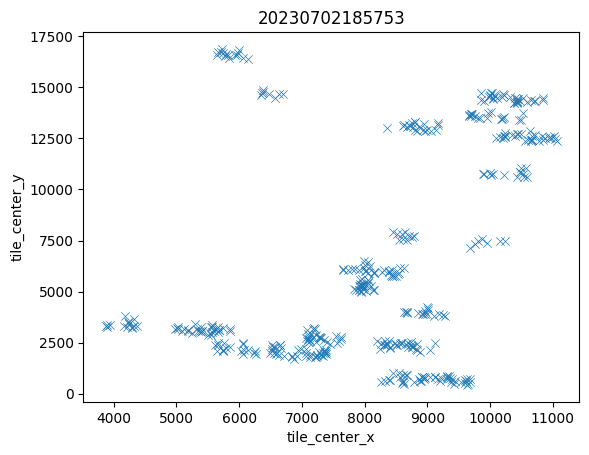

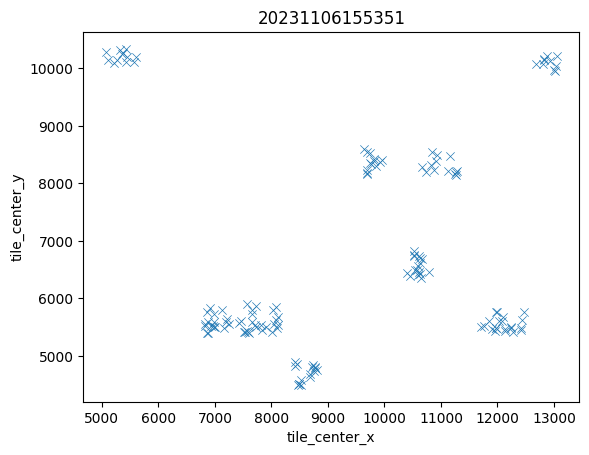

In [ ]:
for fid, group in coords.groupby('fragment_id'):
    ax = sns.scatterplot(group, x='tile_center_x', y='tile_center_y', marker='x')
    ax.set_title(fid)
    plt.show()


In [ ]:
voxels, labels, idxs = [], [], []
# loop through each fragment
for fragment_id, fragment_group in tqdm(coords.groupby('fragment_id'), desc='Loading voxels and labels...'):
    data, label = read_fragment(fragment_id, fragment_group, start_slice=start_slice, end_slice=end_slice, big_tile_size=big_tile_size)
    for i, (voxel, mask) in enumerate(zip(data, label)):
        for y in range(0, big_tile_size, small_tile_size):
            for x in range(0, big_tile_size, small_tile_size):
                voxels.append(voxel[y:y+small_tile_size, x:x+small_tile_size])
                labels.append(mask[y:y+small_tile_size, x:x+small_tile_size])
                idxs.append(fragment_group.index[i])
voxels = np.array(voxels)
labels = np.array(labels)
idxs = np.array(idxs)

Loading voxels and labels...:   0%|          | 0/2 [00:00<?, ?it/s]

Loading voxels and labels...: 100%|██████████| 2/2 [01:04<00:00, 32.48s/it]


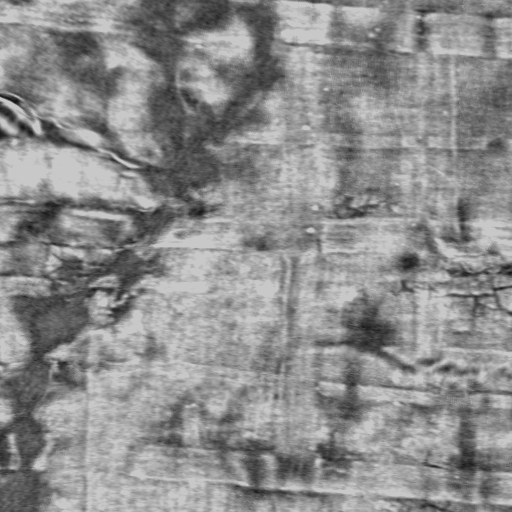

In [ ]:
Image.fromarray(voxel[:, :, 15])

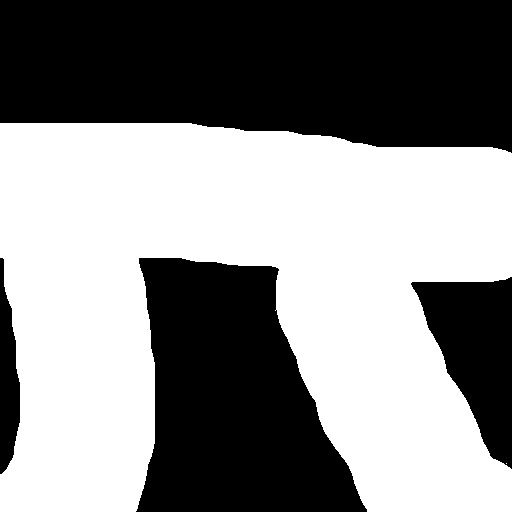

In [ ]:
Image.fromarray((mask[:, :, 0] * 255).astype(np.uint8))

In [ ]:
df.loc[fragment_group.index[i]]

tile_center_x                         12248
tile_center_y                          5499
ink_fraction                          0.729
fragment_id                  20231106155351
confidence                           yellow
mask_filename    20231106155351_yellow0.png
Name: 102, dtype: object

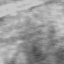

In [ ]:
Image.fromarray(voxels[0][:, :, 15])

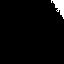

In [ ]:
Image.fromarray((labels[0][:, :, 0] * 255).astype(np.uint8))

# Compare with Youssef

In [98]:
model1 = RegressionPLModel()
model2 = RegressionPLModel.load_from_checkpoint('./models/BASE_MODEL_valid_20230827161847_0_fr_i3depoch=7.ckpt', strict=False)
model3 = RegressionPLModel.load_from_checkpoint('./models/i3d_trial0.ckpt', strict=False)
model4 = RegressionPLModel.load_from_checkpoint('./models/i3d_trial1epoch=7.ckpt', strict=False)
model5 = RegressionPLModel.load_from_checkpoint('./models/iteration1/i3d_iteration1.ckpt', strict=False)

In [99]:
from inference import get_img_splits, predict_fn
from inference import args
args.segment_path = DATA_PATH
test_loader, test_xyxz, test_shape, fragment_mask = get_img_splits(
    '20230519195952',
    start_slice,
    end_slice,
    None, # height window
    None, # width window
    batch_size=128,
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict(model):
    model = model.cuda()
    pred = predict_fn(test_loader, model, device, test_xyxz, test_shape)
    pred = np.clip(np.nan_to_num(pred),a_min=0,a_max=1)
    pred/= pred.max()
    pred = (pred*255).astype(np.uint8)
    return pred

100%|██████████| 63225/63225 [00:00<00:00, 202517.00it/s]


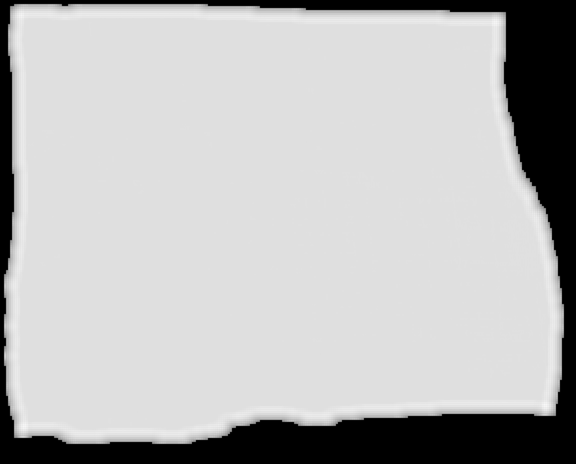

In [31]:
pred = predict(model1)
Image.fromarray(pred).resize((int(pred.shape[1]/4), int(pred.shape[0]/4)))

100%|██████████| 406/406 [02:25<00:00,  2.78it/s]
c:\Users\Epicurus\Documents\Scrolls-Project\epicurus2.0\inference.py:185: RuntimeWarning: invalid value encountered in divide
  mask_pred /= mask_count


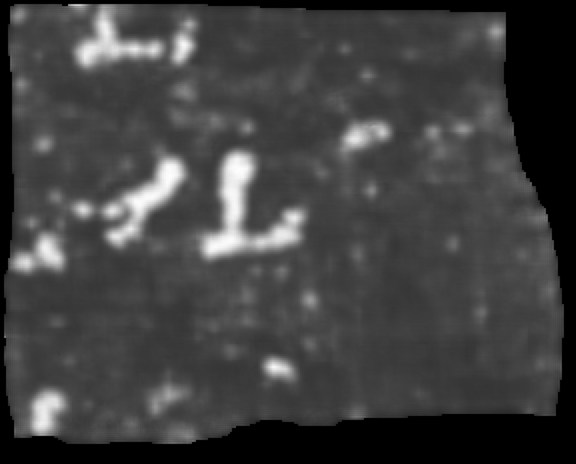

In [113]:
pred = predict(model2)
Image.fromarray(pred).resize((int(pred.shape[1]/4), int(pred.shape[0]/4)))

100%|██████████| 406/406 [02:22<00:00,  2.84it/s]
c:\Users\Epicurus\Documents\Scrolls-Project\epicurus2.0\inference.py:189: RuntimeWarning: invalid value encountered in divide
  mask_pred /= mask_count


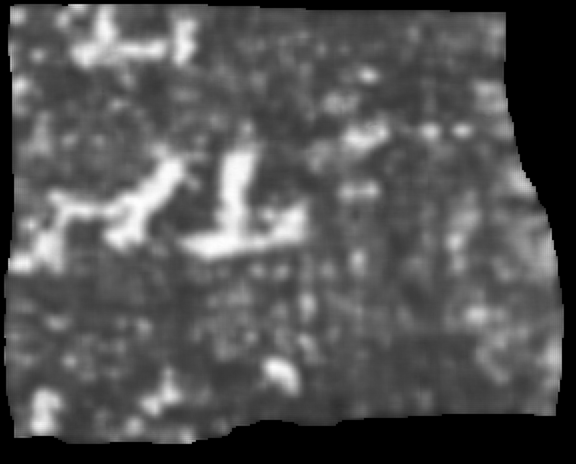

In [9]:
pred = predict(model4)
Image.fromarray(pred).resize((int(pred.shape[1]/4), int(pred.shape[0]/4)))

100%|██████████| 406/406 [02:22<00:00,  2.85it/s]
c:\Users\Epicurus\Documents\Scrolls-Project\epicurus2.0\inference.py:185: RuntimeWarning: invalid value encountered in divide
  mask_pred /= mask_count


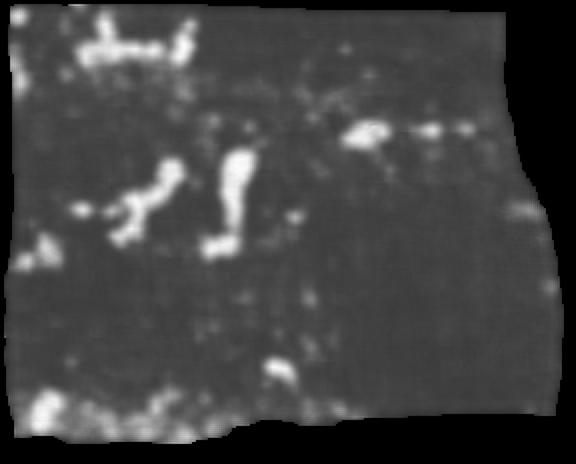

In [20]:
pred = predict(model5)
Image.fromarray(pred).resize((int(pred.shape[1]/4), int(pred.shape[0]/4)))